# Instructions 
* To run this code successfully, you need to use Jupyter running a Kernel with Python 3.7 and Spark 2.4.7
* You need to install libraries pandas, pandas_profiling, plotly, bioinfokit, scipy, h20, datetime, matplotlib, functools, glob

## Import Required Libraries

In [1]:
import pandas as pd
from pyspark.sql.types import DateType, LongType, StringType, StructType, StructField, IntegerType
import pyspark.sql.functions as F
from pandas_profiling import ProfileReport
import plotly.graph_objects as go
from pyspark.sql.window import Window
from bioinfokit.analys import get_data, stat
from scipy import stats as st
import h2o
import datetime as dt
import shap
import matplotlib.pyplot as plt
import functools
import glob
import numpy as np

## Define functions

In [2]:
#Function to ungroup the data that are grouped in struct or array
def flatten_df(nested_df):
    flat_cols = [c[0] for c in nested_df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in nested_df.dtypes if c[1][:6] == 'struct']
    flat_df = nested_df.select(flat_cols +
                              [F.col(nc+'.'+c).alias(nc+'_'+c)
                                for nc in nested_cols
                                for c in nested_df.select(nc+'.*').columns])
    return flat_df

## Import dataset

In [3]:
%%time
sdf=spark.read.parquet('datasets/parquet/')
sdf.printSchema()
sdf.count();

root
 |-- epochMillis: long (nullable = true)
 |-- mmsi: long (nullable = true)
 |-- position: struct (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- navigation: struct (nullable = true)
 |    |-- navCode: long (nullable = true)
 |    |-- navDesc: string (nullable = true)
 |    |-- courseOverGround: double (nullable = true)
 |    |-- heading: double (nullable = true)
 |    |-- rateOfTurn: double (nullable = true)
 |    |-- speedOverGround: double (nullable = true)
 |-- olson_timezone: string (nullable = true)
 |-- vesselDetails: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- typeName: string (nullable = true)
 |    |-- typeCode: long (nullable = true)
 |    |-- draught: double (nullable = true)
 |    |-- length: long (nullable = true)
 |    |-- width: long (nullable = true)
 |    |-- flagCode: long (nullable = true)
 |    |-- flagCountry: string (nullable = true)
 |-- port: struct (nullable =

3473877

## Data transformation

In [4]:
#I want to flatten the nested variable to non-nested variable to possibilite the EDA using pandas_profiling library
df_unnested_tmp=flatten_df(sdf)
spark.conf.set("spark.sql.session.timeZone", "Asia/Shanghai")
df_unnested_tmp = df_unnested_tmp.withColumn("datetime", F.from_utc_timestamp(F.to_timestamp(F.col("epochMillis")/1000),"UTC"))\
.withColumn('date', F.substring('datetime', 1, 10))\
.withColumn('month', F.substring('datetime', 1, 7))
df_unnested_tmp.printSchema()

root
 |-- epochMillis: long (nullable = true)
 |-- mmsi: long (nullable = true)
 |-- olson_timezone: string (nullable = true)
 |-- imo: long (nullable = true)
 |-- callSign: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- cargoDetails: string (nullable = true)
 |-- position_latitude: double (nullable = true)
 |-- position_longitude: double (nullable = true)
 |-- navigation_navCode: long (nullable = true)
 |-- navigation_navDesc: string (nullable = true)
 |-- navigation_courseOverGround: double (nullable = true)
 |-- navigation_heading: double (nullable = true)
 |-- navigation_rateOfTurn: double (nullable = true)
 |-- navigation_speedOverGround: double (nullable = true)
 |-- vesselDetails_name: string (nullable = true)
 |-- vesselDetails_typeName: string (nullable = true)
 |-- vesselDetails_typeCode: long (nullable = true)
 |-- vesselDetails_draught: double (nullable = true)
 |-- vesselDetails_length: long (nullable = true)
 |-- vesselDetails_width: long (nullab

## EDA with Pandas Profiling
##### For more details on the pandas profiling library see https://github.com/pandas-profiling/pandas-profiling

In [5]:
#Generate report
#The database is huge, It has 3,473,877 records. Because of this I dicied to use a 30% SRS (simple random sample) without replacement for EDA
profile = ProfileReport(df_unnested_tmp.sample(fraction=0.3, seed=3).toPandas(), title=f"Pandas Profiling Report Ocean AIS dwell dataset"
                        ,explorative=True
                        ,samples=None
                        ,correlations=None
                        ,missing_diagrams=None
                        ,duplicates=None
                        ,interactions=None
                       )
profile.to_file("profile.html")
display(profile)

### VERY IMPORTANT: After the EDA, it was possible to confirm that there are 33,152 duplicate records in the dataset. All duplicate records were removed and all responses were made considering the deduplicated dataset.
### See the evidence below. Two completely identical records:

In [6]:
df_unnested_tmp.filter((F.col('epochMillis')==1553574152000) & (F.col('mmsi')==412372140))\
.orderBy(F.col("mmsi").asc()).toPandas().to_dict()

{'epochMillis': {0: 1553574152000, 1: 1553574152000},
 'mmsi': {0: 412372140, 1: 412372140},
 'olson_timezone': {0: 'Asia/Shanghai', 1: 'Asia/Shanghai'},
 'imo': {0: 0, 1: 0},
 'callSign': {0: 'BPEB', 1: 'BPEB'},
 'destination': {0: 'SHANGHAI', 1: 'SHANGHAI'},
 'cargoDetails': {0: None, 1: None},
 'position_latitude': {0: 31.378744, 1: 31.378744},
 'position_longitude': {0: 121.572655, 1: 121.572655},
 'navigation_navCode': {0: 0, 1: 0},
 'navigation_navDesc': {0: 'Under Way Using Engine',
  1: 'Under Way Using Engine'},
 'navigation_courseOverGround': {0: 221.7, 1: 221.7},
 'navigation_heading': {0: 252.0, 1: 252.0},
 'navigation_rateOfTurn': {0: 0.0, 1: 0.0},
 'navigation_speedOverGround': {0: 0.7, 1: 0.7},
 'vesselDetails_name': {0: 'JIHAIZHONGSHAN', 1: 'JIHAIZHONGSHAN'},
 'vesselDetails_typeName': {0: 'Cargo', 1: 'Cargo'},
 'vesselDetails_typeCode': {0: 70, 1: 70},
 'vesselDetails_draught': {0: 5.0, 1: 5.0},
 'vesselDetails_length': {0: 100, 1: 100},
 'vesselDetails_width': {0: 16,

In [5]:
#removing duplicates
print("With duplicates: " + str(df_unnested_tmp.count()))
#Persist the dataframe df_unnested because it will  be used for all the next steps
df_unnested = df_unnested_tmp.drop_duplicates().persist()
print("Without duplicates: " + str(df_unnested.count()))

With duplicates: 3473877
Without duplicates: 3440725


## Conclusion of the dataset
I understand that the dataset mainly shows the locations, date and time and status of vessels in the port of Shanghai, China. The chart below shows tracking the location and status of a specific vessel entering the port of Shanghai

In [8]:
#Choose a vessel informing the MMSI
vessel_mmsi=205792000

df = df_unnested.select('mmsi', 'navigation_navCode', 'navigation_navDesc', 'datetime', 'position_latitude', 'position_longitude')\
.filter(F.col('mmsi')==vessel_mmsi).orderBy(F.col("datetime").asc()).toPandas()
df

mmsi  navigation_navCode      navigation_navDesc  \
0    205792000                   5                  Moored   
1    205792000                   5                  Moored   
2    205792000                   5                  Moored   
3    205792000                   5                  Moored   
4    205792000                   1               At Anchor   
..         ...                 ...                     ...   
179  205792000                   0  Under Way Using Engine   
180  205792000                   0  Under Way Using Engine   
181  205792000                   0  Under Way Using Engine   
182  205792000                   0  Under Way Using Engine   
183  205792000                   0  Under Way Using Engine   

               datetime  position_latitude  position_longitude  
0   2020-03-23 15:23:38          31.296667          122.734000  
1   2020-03-23 15:33:59          31.280333          122.702160  
2   2020-03-23 15:44:18          31.269833          122.683000  
3   2020-03-23 15:58:32          31.265375          122.671030  
4   2020-03-23 16:19:31          31.263000          122.670670  
..                  ...                ...                 ...  
179 2020-03-25 17:02:52          31.094500          122.510330  
180 2020-03-25 17:13:04          31.087833          122.558500  
181 2020-03-25 17:14:28          31.088500          122.565500  
182 2020-03-25 17:37:22          31.081333          122.691666  
183 2020-03-25 17:51:28          31.074333          122.776000  

[184 rows x 6 columns]

In [9]:
#ZOOM the chart to see the navigation status
fig = go.Figure(data=go.Scattergeo(
        lon = df['position_longitude'], lat = df['position_latitude'],
        text = df['navigation_navDesc'],
        mode = 'markers',
        marker_color = df['navigation_navCode'],
        ))

# focus point
lat_foc = df['position_latitude'].mean()
lon_foc = df['position_longitude'].mean()
fig.update_layout(
        geo = dict(
            showland = True,
            scope='asia',
            projection_scale=50, #this is kind of like zoom
            center=dict(lat=lat_foc, lon=lon_foc), # this will center on the point
        ))

fig.show()

## Answering the questions

### 3.	What is(are) the main time period(s) in the data?

### Answer: The data presents a time period of 16 days; however 8 days are from last week of march of 2019 and 8 days from last week of march of 2020. It is possible to identify in the graph that on Saturdays the activities of the vessels are much lower than the other days of the week. For some analyses, it would be a good idea to consider just two different periods, March 2019 and March 2020

In [72]:
df3 = df_unnested.select('date')\
.groupBy('date').agg(F.count("date").alias("records_qty"))\
.orderBy(F.col("date").asc())\
.toPandas()
df3

date  records_qty
0   2019-03-23       158494
1   2019-03-24       229192
2   2019-03-25       234783
3   2019-03-26       248032
4   2019-03-27       247134
5   2019-03-28       267625
6   2019-03-29       274174
7   2019-03-30        95757
8   2020-03-21       161567
9   2020-03-22       242266
10  2020-03-23       241431
11  2020-03-24       233368
12  2020-03-25       238720
13  2020-03-26       244669
14  2020-03-27       239179
15  2020-03-28        84334

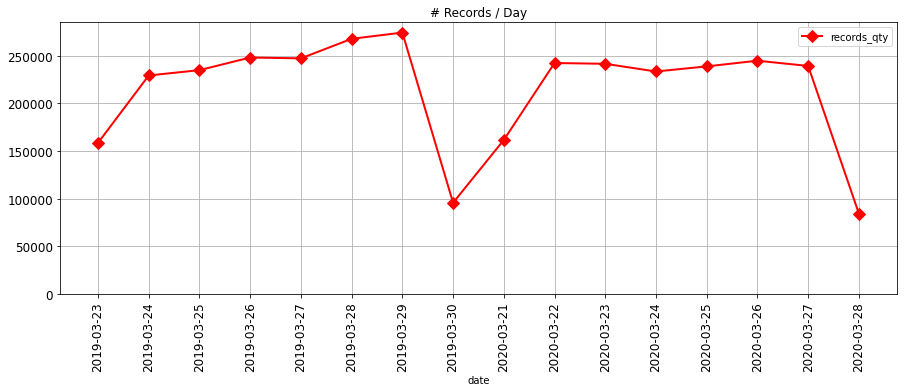

In [11]:
ax = df3.set_index('date').plot(xticks=df3.index, ylim=[0,285000], secondary_y=False, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1, title=("# Records / Day"), x_compat=True)

In [73]:
df3 = df_unnested.select('month')\
.groupBy('month').agg(F.count("month").alias("records_qty"))\
.orderBy(F.col("month").asc())\
.toPandas()
df3

month  records_qty
0  2019-03      1755191
1  2020-03      1685534

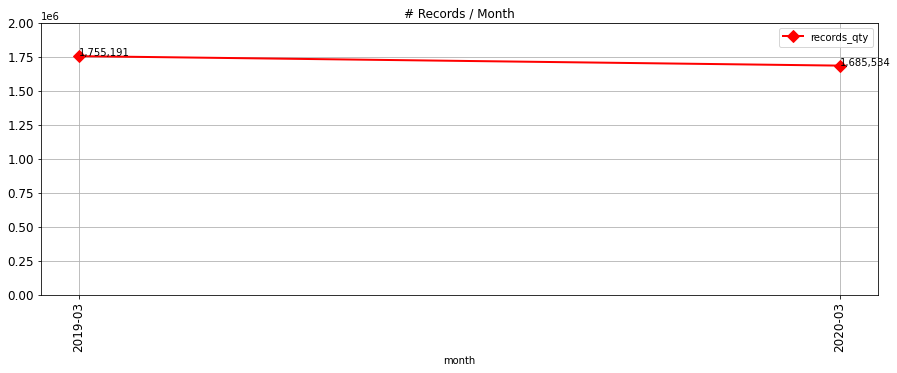

In [114]:
ax = df3.set_index('month').plot(ylim=[0, 2000000],xticks=df3.index, secondary_y=False, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1, title=("# Records / Month"), x_compat=True)

for p in range(len(df3)):
    ax.annotate('{:,.0f}'.format(df3.reset_index().iloc[p,2]), (df3.reset_index().iloc[p,0], df3.reset_index().iloc[p,2]))

### 4. Which are the top three most sparse variables?
### Answer: The top three most sparse variables are navigation_rateOfTurn, imo, navigation_speedOverGround. I used the highest coefficient of variation to determine the most sparsas variables.

In [12]:
def calculated_cv(df):
    data= {'Column': [], 'coefficient_of_variation': []}
    num_cols = [c[0] for c in df.dtypes if c[1][:6] in ('bigint', 'double')]
    for i in num_cols:
        cv=df.select(i).groupBy()\
        .agg(F.avg(i).alias("avg"), F.stddev(i).alias("stddev"))\
        .withColumn('Column', F.lit(i))\
        .withColumn('coefficient_of_variation', F.col('stddev') / F.col('avg')).select('coefficient_of_variation')
        data['Column'].append(i)
        data['coefficient_of_variation'].append(abs(cv.toPandas()['coefficient_of_variation'][0]))
        
    df_cv = pd.DataFrame.from_dict(data)
    return df_cv

In [13]:
%%time
df_cv = calculated_cv(df_unnested)
pd.options.display.float_format = '{:.2%}'.format
df_cv.sort_values(by='coefficient_of_variation', ascending=False).iloc[:3,:]

Wall time: 39.7 s


Column  coefficient_of_variation
8       navigation_rateOfTurn                  3428.79%
2                         imo                   526.10%
9  navigation_speedOverGround                   144.82%

In [14]:
pd.reset_option('display.float_format')

### 5. What region(s) of the world and ocean port(s) does this data represent? Provide evidence to justify your answer.

### Answer: There are many evidences that this data represent The Port of Shanghai, located on the outskirts of the Chinese city of Shanghai, That can be accessed by East China Sea and Hangzhou Bay as well as the Yangtze and Huangpu Rivers. I chose three evidences in the dataset:
### i. The only port name in the dataset is Shanghai Port
### ii. The only time zone in the dataset is Asia/Shanghai
### iii. The coordinates of the events are between 30º to 32º of latitude, 120º and 123º of longitude, and these coordinates represent the region around the port of shanghai

In [15]:
df_unnested.select('port_name').groupBy('port_name').count().show()

+-----------+-------+
|  port_name|  count|
+-----------+-------+
|SHANGHAI PT|3440725|
+-----------+-------+



In [16]:
df_unnested.select('olson_timezone').groupBy('olson_timezone').count().show()

+--------------+-------+
|olson_timezone|  count|
+--------------+-------+
| Asia/Shanghai|3440725|
+--------------+-------+



In [17]:
df_unnested.select('position_longitude').groupBy()\
.agg(F.min('position_longitude').alias("min_position_longitude"), F.max('position_longitude').alias("max_position_longitude")).show()

+----------------------+----------------------+
|min_position_longitude|max_position_longitude|
+----------------------+----------------------+
|            120.756256|             123.55666|
+----------------------+----------------------+



In [18]:
df_unnested.select('position_latitude').groupBy()\
.agg(F.min('position_latitude').alias("min_position_latitude"), F.max('position_latitude').alias("max_position_latitude")).show()

+---------------------+---------------------+
|min_position_latitude|max_position_latitude|
+---------------------+---------------------+
|             30.02688|             32.65971|
+---------------------+---------------------+



## 6. Provide a frequency tabulation of the various Navigation Codes & Descriptions (i.e., navCode & NavDesc). Optionally, provide any additional statistics you find interesting

In [19]:
NavDesc_df = df_unnested.select('navigation_navCode', 'navigation_navDesc', 'navigation_speedOverGround', 'navigation_rateOfTurn').groupBy('navigation_navCode', 'navigation_navDesc')\
.agg(F.count('navigation_navCode').alias('quantity'), F.avg('navigation_speedOverGround').alias("avg_speedOverGround"), F.avg('navigation_rateOfTurn').alias("avg"), F.stddev('navigation_rateOfTurn').alias("stddev_rateOfTurn")).withColumn('cv_rateOfTurn', F.col('stddev_rateOfTurn') / F.col('avg'))\
.drop('avg').orderBy(F.col("quantity").desc())
NavDesc_df_pandas = NavDesc_df.toPandas()
NavDesc_df_pandas['quantity']=NavDesc_df_pandas['quantity'].astype(float)
pd.options.display.float_format = '{:,.2f}'.format
NavDesc_df_pandas.reset_index(drop=True, inplace=True)
NavDesc_df_pandas

navigation_navCode             navigation_navDesc     quantity  \
0                   16                        Unknown 1,340,821.00   
1                    0         Under Way Using Engine 1,057,447.00   
2                    5                         Moored   548,325.00   
3                    1                      At Anchor   422,862.00   
4                   15                    Not Defined    29,179.00   
5                    8               Underway Sailing    24,782.00   
6                    3     Restricted Manoeuvrability     8,237.00   
7                    2              Not Under Command     3,455.00   
8                    4     Constrained By Her Draught     1,450.00   
9                    9  Reserved For Future Amendment     1,353.00   
10                  11        Reserved For Future Use     1,220.00   
11                  13        Reserved For Future Use       875.00   
12                   6                        Aground       401.00   
13                   7             Engaged In Fishing       311.00   
14                  12        Reserved For Future Use         7.00   

    avg_speedOverGround  stddev_rateOfTurn  cv_rateOfTurn  
0                  2.66               2.12         -56.97  
1                  5.96               7.02         -20.46  
2                  0.31               6.71        -225.00  
3                  0.32               4.14        -154.72  
4                  1.09              15.88          -7.45  
5                  2.75              14.93          -8.97  
6                  0.97               1.86         -67.69  
7                  1.40               9.57         -13.34  
8                  1.28               0.44         642.47  
9                  1.54              22.83          -5.13  
10                 0.88               0.00            NaN  
11                 0.06               0.00            NaN  
12                 1.10               1.48         -56.58  
13                 5.31               0.00            NaN  
14                 9.19               0.00            NaN

In [20]:
pd.reset_option('display.float_format')

### 7. For MMSI = 205792000, provide the following report:
### a. Limit the data to only the TOP 5 Navigation Codes based from the response to question 6:
### Answer: The limited date for MMSI = 205792000 has 184 records considering only the TOP 5 Navigation Codes 16, 0, 5, 1, 15

In [122]:
df_unnested.registerTempTable("df_unnested")
df_mmsi_205792000 = sql("select * from df_unnested where mmsi = 205792000 and navigation_navCode in (16, 0, 5, 1, 15)")
df_mmsi_205792000.count()

b. Provide the final state for each series of contiguous events with the same Navigation Code; series may be interrupted by other series, but each contiguous series must be its own record. <br>
c.Final report should include at least the following fields/columns:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i.	mmsi = the MMSI of the vessel<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ii.	timestamp = the timestamp of the last event in that contiguous series<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;iii.	Navigation Code = the navigation code (i.e., navigation.navCode)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;iv.	Navigation Description = the navigation code description (i.e., navigation.navDesc)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;v.	lead time (in Milliseconds) = the time difference in milliseconds between the last and first timestamp of that particular series of the same contiguous navigation codes<br>

### Answer: It was necessary to create the navigation_navDescID column to identify each contiguous series. 
### Without this approach it would not be possible to separate the first Morred from the Morred as shown in the example above.

In [138]:
df_mmsi_205792000_t2 = df_mmsi_205792000.withColumn('navigation_navDesc_lag', F.lag(F.col('navigation_navDesc'),1).over(Window.partitionBy('mmsi', 'month').orderBy(F.col("datetime").asc())))\
.withColumn('navDesc_id_tmp', F.when(F.col('navigation_navDesc_lag')==F.col('navigation_navDesc'), 0).otherwise(1))

In [139]:
window_func = Window.partitionBy("mmsi").orderBy("datetime").rowsBetween(
    Window.unboundedPreceding,  # Take all rows from the beginning of frame
    Window.currentRow           # To current row
)

df_mmsi_205792000_t3=df_mmsi_205792000_t2.withColumn("navDesc_id", F.sum("navDesc_id_tmp").over(window_func))\
.orderBy("datetime")\
.withColumn('navigation_navDescID', F.concat(F.trim(F.col('navDesc_id').cast(StringType())),F.lit(' - '),F.trim(F.col('navigation_navDesc').cast(StringType()))))

In [140]:
#Register df_mmsi_205792000 as table
df_mmsi_205792000_t3.registerTempTable("df_mmsi_205792000_t3")

In [141]:
sql('''
select mmsi
,first_datetime
,last_datetime
,navigation_navCode
,navigation_navDescID
,(last_epochMillis-first_epochMillis) as lead_time_milliseconds
,cast((last_epochMillis-first_epochMillis)/1000/60 as integer) as lead_time_minutes
from
(
select
 mmsi
,navigation_navCode
,navigation_navDescID
,min(datetime) as first_datetime
,max(datetime) as last_datetime
,min(epochMillis) as first_epochMillis
,max(epochMillis) as last_epochMillis
from df_mmsi_205792000_t3
group by
 mmsi
,navigation_navCode
,navigation_navDescID
) order by first_datetime''').toPandas()

mmsi      first_datetime       last_datetime  navigation_navCode  \
0  413381030 2019-03-23 07:43:55 2019-03-30 07:29:46                   1   
1  413381030 2020-03-21 07:53:51 2020-03-23 12:51:15                   1   
2  413381030 2020-03-23 12:55:15 2020-03-23 18:27:54                   0   
3  413381030 2020-03-23 19:03:04 2020-03-28 07:34:52                   1   

         navigation_navDescID  lead_time_milliseconds  lead_time_minutes  
0               1 - At Anchor               603951000              10065  
1               2 - At Anchor               190644000               3177  
2  3 - Under Way Using Engine                19959000                332  
3               4 - At Anchor               390708000               6511

### 8.	For MMSI = 413970021, provide the same report as number 7
a.	Do you agree with the Navigation Code(s) and Description(s) for this particular vessel?<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i.	If you do agree, provide an explanation why you agree.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ii.	If you do not agree, provide an explanation why do disagree. Additionally, if you do not agree, what would you change it to and why?<br>

### Answer: Unfortunately the Navigation Code for this particular vessel is defined as 16 (Unknown). 
### Because of this is not possible to know each series of contiguous events and judge if I agree or not with the navegation
### What I would do differently would be to improve the system to correctly capture each ship state change

In [26]:
df_unnested.registerTempTable("df_unnested")
df_mmsi_413970021 = sql("select * from df_unnested where mmsi = 413970021")
df_mmsi_413970021.count()

362

In [27]:
df_mmsi_413970021_t2 = df_mmsi_413970021.withColumn('navigation_navDesc_lag', F.lag(F.col('navigation_navDesc'),1).over(Window.partitionBy('mmsi').orderBy(F.col("datetime").asc())))\
.withColumn('navDesc_id_tmp', F.when(F.col('navigation_navDesc_lag')==F.col('navigation_navDesc'), 0).otherwise(1))

window_func = Window.partitionBy("mmsi").orderBy("datetime").rowsBetween(
    Window.unboundedPreceding,  # Take all rows from the beginning of frame
    Window.currentRow           # To current row
)

df_mmsi_413970021_t3=df_mmsi_413970021_t2.withColumn("navDesc_id", F.sum("navDesc_id_tmp").over(window_func))\
.orderBy("datetime")\
.withColumn('navigation_navDescID', F.concat(F.trim(F.col('navDesc_id').cast(StringType())),F.lit(' - '),F.trim(F.col('navigation_navDesc').cast(StringType()))))


#Register df_mmsi_413970021 as table
df_mmsi_413970021_t3.registerTempTable("df_mmsi_413970021_t3")

sql('''
select mmsi
,first_datetime
,last_datetime
,navigation_navCode
,navigation_navDescID
,(last_epochMillis-first_epochMillis) as lead_time_milliseconds
,cast((last_epochMillis-first_epochMillis)/1000/60 as integer) as lead_time_minutes
from
(
select
 mmsi
,navigation_navCode
,navigation_navDescID
,min(datetime) as first_datetime
,max(datetime) as last_datetime
,min(epochMillis) as first_epochMillis
,max(epochMillis) as last_epochMillis
from df_mmsi_413970021_t3
group by
 mmsi
,navigation_navCode
,navigation_navDescID
) order by first_datetime''').toPandas()

mmsi      first_datetime       last_datetime  navigation_navCode  \
0  413970021 2019-03-23 07:49:54 2019-03-30 04:16:09                  16   

  navigation_navDescID  lead_time_milliseconds  lead_time_minutes  
0          1 - Unknown               591975000               9866

### 9. For each of the time period(s) from item three, provide a tabulation of the top 10 series of vessel navigation code/description ordered states.
### Answer: see the chart bellow

In [38]:
#TOP 10 series
df_unnested.groupBy('navigation_navDesc', 'navigation_navCode').count()\
.orderBy(F.col("count").desc()).limit(10).toPandas()

navigation_navDesc  navigation_navCode    count
0                        Unknown                  16  1340821
1         Under Way Using Engine                   0  1057447
2                         Moored                   5   548325
3                      At Anchor                   1   422862
4                    Not Defined                  15    29179
5               Underway Sailing                   8    24782
6     Restricted Manoeuvrability                   3     8237
7              Not Under Command                   2     3455
8     Constrained By Her Draught                   4     1450
9  Reserved For Future Amendment                   9     1353

In [ ]:
df_unnested_per_month = df_unnested.withColumn('date', F.substring('datetime', 1, 10))

In [40]:
#Register df_unnested as table
df_unnested.registerTempTable("df_unnested")

df_unnested_per_month = sql('''
select *
,SUBSTRING(datetime, 1, 10 ) as date
from df_unnested
where
navigation_navCode in (16, 0, 5, 1, 15, 8, 3, 2, 4, 9)
''')

In [41]:
df9 = df_unnested_per_month.groupBy('date', 'navigation_navDesc').count()\
.groupBy('date').pivot("navigation_navDesc").agg(F.sum(F.col("count"))).na.fill(0).toPandas()
df9

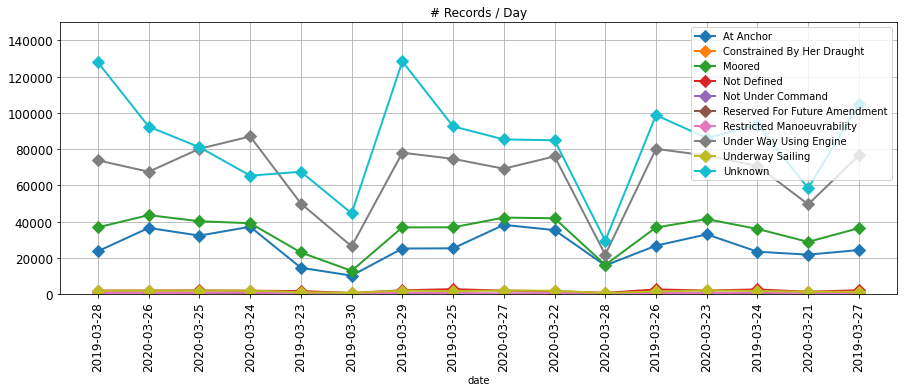

In [47]:
ax = df9.set_index('date').plot(xticks=df9.index, ylim=[0,150000], secondary_y=False, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, legend=1, title=("# Records / Day"), x_compat=True)

### 10. Using the results from item 9, compare the volume of each vessel navigation code/description ordered states for each time period(s) from item three.
### a. Which increased/decreased?

### Answer: Analyzing the graph with daily information is not the best way to confirm which one has increased or decreased. So I decided to create a monthly chart . Analyzing the monthly chart, it is possible to confirm that “Unknown” had a considerable decrease, and “Moored” and "At Anchor" increased.

In [53]:
df10 = df_unnested_per_month.withColumn('month', F.substring('datetime', 1, 7))\
.groupBy('month', 'navigation_navDesc').count()\
.groupBy('month').pivot("navigation_navDesc").agg(F.sum(F.col("count"))).na.fill(0).toPandas()

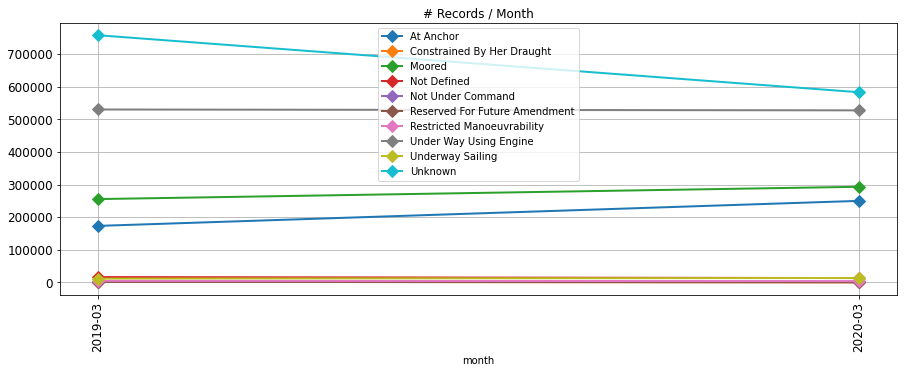

In [54]:
ax = df10.set_index('month').plot(xticks=df10.index, secondary_y=False, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, legend=1, title=("# Records / Month"), x_compat=True)

### 11. For each of the time period(s) from item three and using only the “At Anchor” and “Moored” navigation descriptions, quantify the average “dwell”
### Answer: The average number of dwell type events received per day is 60699 and on average the vessels are stopped for 704 minutes in the dwell states. However on Saturdays the  average is 4 times bigger (2605 minutes), indicating that there is not much movement at the port of shanghai that day.

In [58]:
#Average number of "dwell" events received per day:
df11 = df9.copy()
df11['dwell'] = df11['At Anchor'] + df11['Moored']
df11['dwell'].mean()

60699.1875

In [144]:
#Average time (minutes) in "dwell" status per day:
df_unnested_t2 = df_unnested.withColumn('navigation_navDesc_lag', F.lag(F.col('navigation_navDesc'),1).over(Window.partitionBy('mmsi', 'month').orderBy(F.col("datetime").asc())))\
.withColumn('navDesc_id_tmp', F.when(F.col('navigation_navDesc_lag')==F.col('navigation_navDesc'), 0).otherwise(1))

window_func = Window.partitionBy("mmsi").orderBy("datetime").rowsBetween(
    Window.unboundedPreceding,  # Take all rows from the beginning of frame
    Window.currentRow           # To current row
)

df_unnested_t3=df_unnested_t2.withColumn("navDesc_id", F.sum("navDesc_id_tmp").over(window_func))\
.orderBy("datetime")\
.withColumn('navigation_navDescID', F.concat(F.trim(F.col('navDesc_id').cast(StringType())),F.lit(' - '),F.trim(F.col('navigation_navDesc').cast(StringType()))))

#Register df_unnested as table
df_unnested_t3.registerTempTable("df_unnested_t3")

df_unnested_t4 = sql('''
select mmsi
,first_datetime
,last_datetime
,SUBSTRING(last_datetime, 1, 10 ) as last_date
,navigation_navCode
,navigation_navDescID
,(last_epochMillis-first_epochMillis) as lead_time_milliseconds
,cast((last_epochMillis-first_epochMillis)/1000/60 as integer) as lead_time_minutes
from
(
select
 mmsi
,navigation_navCode
,navigation_navDescID
,min(datetime) as first_datetime
,max(datetime) as last_datetime
,min(epochMillis) as first_epochMillis
,max(epochMillis) as last_epochMillis
from df_unnested_t3
group by
 mmsi
,navigation_navCode
,navigation_navDescID
) order by first_datetime''').persist()


df_unnested_t5 = df_unnested_t4.filter((F.col('navigation_navCode')==1) | (F.col('navigation_navCode')==5))\
.groupBy('last_date').agg(F.avg(F.col("lead_time_minutes")))
df_unnested_t5.printSchema()

root
 |-- last_date: string (nullable = true)
 |-- avg(lead_time_minutes): double (nullable = true)



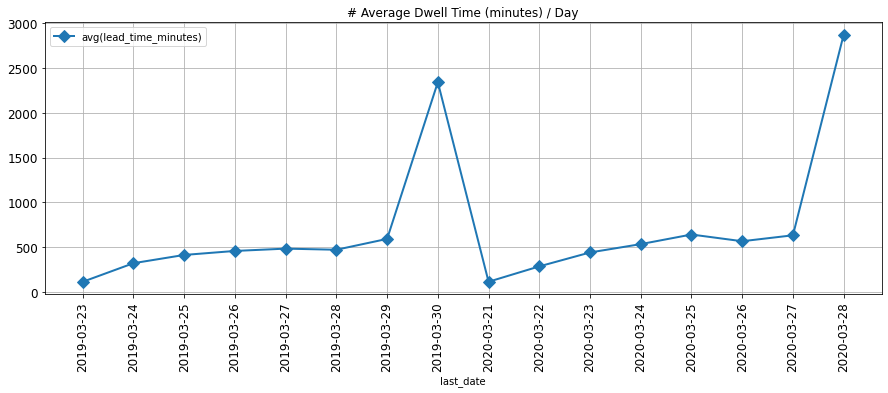

In [152]:
df_unnested_t6 = df_unnested_t5.toPandas()
ax = df_unnested_t6.sort_values(by='last_date', ascending=True).set_index('last_date').plot(xticks=df_unnested_t6.index, secondary_y=False, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, legend=1, title=("# Average Dwell Time (minutes) / Day"), x_compat=True)

In [149]:
# Daily mean in minutes
df_unnested_t6['avg(lead_time_minutes)'].mean()

704.1144871909663

In [157]:
#Average on Satardays:
df_unnested_t6[(df_unnested_t6.last_date=='2019-03-30') | (df_unnested_t6.last_date=='2020-03-28')]['avg(lead_time_minutes)'].mean()

2605.8914103667203

### 12. Describe or show how you would quantify if the difference(s) in “dwells” between the time-period(s) is(are) significant.
### Answer: I did a Two sample t-test to compare the average minutes in “dwells” between "2019-03" and "2020-03". The p value obtained from the t-test is significant (p < 0.05), and therefore, we conclude that the lead_time_minutes of month "2019-03"  is significantly different than month "2020-03".

In [167]:
# Calculate Two sample t-test in Python
df12 = df_unnested_t4.filter((F.col('navigation_navCode')==1) | (F.col('navigation_navCode')==5))\
.withColumn('month', F.substring('last_datetime', 1, 7))\
.select('month','lead_time_minutes')\
.toPandas()

In [172]:
a = df12.loc[df12['month'] == '2019-03', 'lead_time_minutes'].to_numpy()
b = df12.loc[df12['month'] == '2020-03', 'lead_time_minutes'].to_numpy()
st.ttest_ind(a=a, b=b, equal_var=True)

Ttest_indResult(statistic=-5.985693895348041, pvalue=2.178902347311582e-09)

In [173]:
# Perform two sample t-test using bioinfokit
from bioinfokit.analys import stat
res = stat()
# for unequal variance t-test (Welch's t-test) set evar=False
res.ttest(df=df12, xfac="month", res="lead_time_minutes", test_type=2, evar=False)
print(res.summary)




Two sample t-test with unequal variance (Welch's t-test)

------------------  ---------------
Mean diff            -114.809
t                      -6.01909
Std Error              19.0741
df                  30270.8
P-value (one-tail)      8.87081e-10
P-value (two-tail)      1.77416e-09
Lower 95.0%          -152.195
Upper 95.0%           -77.4228
------------------  ---------------

Parameter estimates

Level      Number     Mean    Std Dev    Std Error    Lower 95.0%    Upper 95.0%
-------  --------  -------  ---------  -----------  -------------  -------------
2019-03     14418  623.082    1562.88      13.0159        597.569        648.595
2020-03     15868  737.891    1756.39      13.9431        710.561        765.221



### 13.	Describe or show how you would create a Machine Learning Model to predict “dwell” times for the region.
### a.	Bonus Points: Provide the code and performance results for your machine learning model on an OOB sample.
### b.	In respect of time, performance of the ML model is not important and the number of features can be minimal. What mattes is that the code works and you can explain your thought process if asked.

### Answer: I would suggest validating the model's performance result using an Out Of Time sample dataset instead of using an Out of bag sample, as this way We can verify that we can use the model for future datasets. So I decided to train a machine learning model using 2019 data and validate the model using 2020 data. My first strategy was to try to predict the time in minutes (lead_time_minutes) spent by each vessel in in dwell, using vessel characteristics like width and length. The final model had an R2 of 0.9 and an RMSE of 12 on the out-of-time dataset. The main variables with the greatest impact on the model are ‘vesselDetails_draught’ and ‘vesselDetails_length’ with positive impact, this means that the larger the length of the vessel or the draught needed, the longer it will be stationary in the port. Please, find bellow all independent variables of the final model and the impact of each one using Shapley Value:

In [6]:
# Preparing the dataset for traning the model
#Average time (minutes) in "dwell" status per day:
df_13_unnested_t2 = df_unnested.withColumn('navigation_navDesc_lag', F.lag(F.col('navigation_navDesc'),1).over(Window.partitionBy('mmsi', 'month').orderBy(F.col("datetime").asc())))\
.withColumn('navDesc_id_tmp', F.when(F.col('navigation_navDesc_lag')==F.col('navigation_navDesc'), 0).otherwise(1))

window_func = Window.partitionBy("mmsi").orderBy("datetime").rowsBetween(
    Window.unboundedPreceding,  # Take all rows from the beginning of frame
    Window.currentRow           # To current row
)

df_13_unnested_t3=df_13_unnested_t2.withColumn("navDesc_id", F.sum("navDesc_id_tmp").over(window_func))\
.orderBy("datetime")\
.withColumn('navigation_navDescID', F.concat(F.trim(F.col('navDesc_id').cast(StringType())),F.lit(' - '),F.trim(F.col('navigation_navDesc').cast(StringType()))))

#Register df_13_unnested as table
df_13_unnested_t3.registerTempTable("df_13_unnested_t3")

df_13_unnested_t4 = sql('''
select mmsi
,first_datetime
,last_datetime
,SUBSTRING(last_datetime, 1, 10 ) as last_date
,SUBSTRING(last_datetime, 1, 7) as month
,navigation_navCode
,navigation_navDescID
,vesselDetails_name
,vesselDetails_typeName
,vesselDetails_typeCode
,vesselDetails_draught
,vesselDetails_length
,vesselDetails_width
,vesselDetails_flagCode
,vesselDetails_flagCountry
,(last_epochMillis-first_epochMillis) as lead_time_milliseconds
,cast((last_epochMillis-first_epochMillis)/1000/60 as integer) as lead_time_minutes
from
(
select
 mmsi
,navigation_navCode
,navigation_navDescID
,vesselDetails_name
,vesselDetails_typeName
,vesselDetails_typeCode
,vesselDetails_draught
,vesselDetails_length
,vesselDetails_width
,vesselDetails_flagCode
,vesselDetails_flagCountry
,min(datetime) as first_datetime
,max(datetime) as last_datetime
,min(epochMillis) as first_epochMillis
,max(epochMillis) as last_epochMillis
from df_13_unnested_t3
group by
 mmsi
,navigation_navCode
,navigation_navDescID
,vesselDetails_name
,vesselDetails_typeName
,vesselDetails_typeCode
,vesselDetails_draught
,vesselDetails_length
,vesselDetails_width
,vesselDetails_flagCode
,vesselDetails_flagCountry
) order by first_datetime''').persist()

df_13_unnested_t4.printSchema()

root
 |-- mmsi: long (nullable = true)
 |-- first_datetime: timestamp (nullable = true)
 |-- last_datetime: timestamp (nullable = true)
 |-- last_date: string (nullable = true)
 |-- month: string (nullable = true)
 |-- navigation_navCode: long (nullable = true)
 |-- navigation_navDescID: string (nullable = true)
 |-- vesselDetails_name: string (nullable = true)
 |-- vesselDetails_typeName: string (nullable = true)
 |-- vesselDetails_typeCode: long (nullable = true)
 |-- vesselDetails_draught: double (nullable = true)
 |-- vesselDetails_length: long (nullable = true)
 |-- vesselDetails_width: long (nullable = true)
 |-- vesselDetails_flagCode: long (nullable = true)
 |-- vesselDetails_flagCountry: string (nullable = true)
 |-- lead_time_milliseconds: long (nullable = true)
 |-- lead_time_minutes: integer (nullable = true)



In [18]:
#Save the dataset for modeling
df_13_unnested_t4.write.mode("overwrite").format("parquet").save("datasets/modeling_dataset/")

In [3]:
#Read the dataset for modeling
df_13_unnested_t4=spark.read.parquet('datasets/modeling_dataset/')

In [4]:
#I decided to use only 20% of the dataset for train the model only to avoid memory problems in the task test.
pct_sample_size = 1
if pct_sample_size == 1:
    dataprep_df = df_13_unnested_t4.toPandas()
else:    
    dataprep_df = df_13_unnested_t4.toPandas().sample(frac=pct_sample_size, replace=False, random_state=1)

In [5]:
# It is necessary to create a variable to indicate the records used in training and testing.
dataprep_df['dataset'] = ['train' if x <= '2019-03' else 'test' for x in dataprep_df['month']]

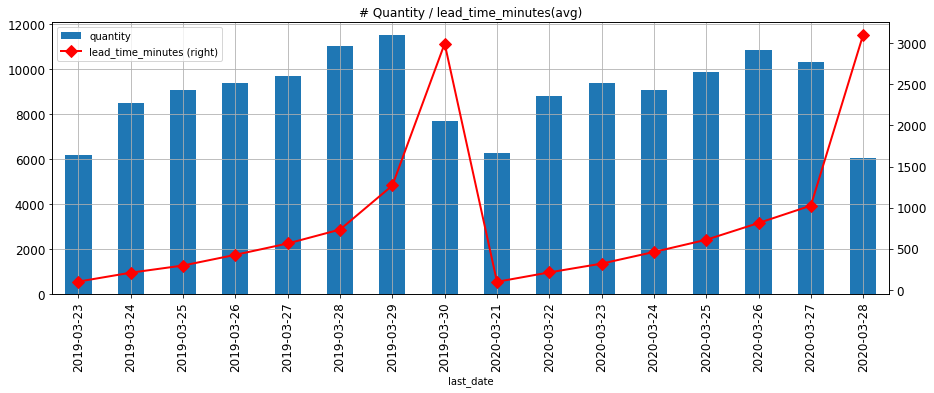

In [60]:
dataprep_target = dataprep_df[['last_date', 'mmsi','lead_time_minutes']].groupby('last_date').agg({'mmsi':'count', 'lead_time_minutes':'mean'})
dataprep_target = dataprep_target.rename(columns = {'mmsi': 'quantity'}, inplace = False)

dataprep_target.quantity.plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Quantity / lead_time_minutes(avg)"))
ax = dataprep_target.lead_time_minutes.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)

#### Feature Engineering

In [6]:
def draught_level_func(draught):
    if draught <= 3.5:
        return 'shallow'
    elif draught <= 5.9:
        return 'deep'
    elif draught <= 10.6:
        return 'very-deep'
    
dataprep_df['draught_level'] = dataprep_df.apply(lambda x: draught_level_func(x['vesselDetails_draught']),axis=1).astype(str)
dataprep_df['vessel_length_by_width'] = dataprep_df['vesselDetails_length'] / dataprep_df['vesselDetails_width']

In [7]:
#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT =  ['vesselDetails_typeName', 'vesselDetails_flagCountry', 'draught_level']
#float
NUM = ['vesselDetails_typeCode', 'vesselDetails_draught', 'vesselDetails_length', 'vesselDetails_width', 'vessel_length_by_width']
selected_features = CAT + NUM

#Model ID
ModelId='dwell_vessel_v2'

#Setting the model target variable name
var_target = 'lead_time_minutes'

#process outputs such as MOJO model, images and performance of tested models
OutputPath='.'

In [8]:
#Tratamento de missing
dataprep_df = dataprep_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [9]:
#Numeric features must be float type
for col_name in NUM:    
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)
#     dataprep_df = dataprep_df.fillna(value={col_name: 0})

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:        
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)    
#     dataprep_df = dataprep_df.fillna(value={col_name: 'missing'})

#### Modeling

In [10]:
# Creating context and H2O and Importing data into the H2O context
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from c:\program files\python37\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\maxde\AppData\Local\Temp\tmpipokvxt2
  JVM stdout: C:\Users\maxde\AppData\Local\Temp\tmpipokvxt2\h2o_maxde_started_from_python.out
  JVM stderr: C:\Users\maxde\AppData\Local\Temp\tmpipokvxt2\h2o_maxde_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         05 secs
H2O_cluster_timezone:       America/Sao_Paulo
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.0.4
H2O_cluster_version_age:    4 days
H2O_cluster_name:           H2O_from_python_maxde_2ge2cp
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.095 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.7 final
--------------------------  -----------------------------

In [11]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "train"').loc[:, (selected_features+['dataset', var_target])])

# Conversion of Target variables and number features to factor (asnumeric)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[var_target] = data_hdf[var_target].asnumeric()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 65541
Validation: 7468


In [12]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "test"').loc[:, (selected_features+['dataset', var_target])])

# Conversion of Target variables and number features to factor (asnumeric)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[var_target] = test_hdf[var_target].asnumeric()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 70658


In [68]:
## GBM - Gradient Boosting Machine
vModel='GBM_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
GBM = H2OGradientBoostingEstimator(model_id='%s%s%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                   ntrees=500,
                                   score_tree_interval=5,     #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   stopping_metric='RMSE',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   seed=1)

# The use of a validation_frame is recommended with using early stopping
GBM.train(x=selected_features, y=var_target, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(GBM)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:08.393888

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_dwell_vessel_v220220403_231630


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              136.0                     136.0              53349.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        0.0        5.0    4.963235         1.0        32.0    24.132353



ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 2966548.612266862
RMSE: 1722.367153735481
MAE: 910.6247021981156
RMSLE: NaN
Mean Residual Deviance: 2966548.612266862

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 3279491.623160369
RMSE: 1810.9366701131128
MAE: 956.1019286916593
RMSLE: NaN
Mean Residual Deviance: 3279491.623160369

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-04-03 23:16:32   0.107 sec              0.0    2027.483292   
1     2022-04-03 23:16:32   0.320 sec              5.0    1915.183893   
2     2022-04-03 23:16:32   0.432 sec             10.0    1864.315915   
3     2022-04-03 23:16:33   0.544 sec             15.0    1833.872947   
4     2022-04-03 23:16:33   0.638 sec             20.0    1816.931438   
5     2022-04-03 23:16:33   0.716 sec             25.0    1805.280494   
6     2022-04-03 23:16:33   0.804 sec             30.0    1798.029967   
7     2022-04-03 23:16:33   0.888 sec             35.0    1791.706008   
8     2022-04-03 23:16:33   0.970 sec             40.0    1786.582371   
9     2022-04-03 23:16:33   1.060 sec             45.0    1781.588859   
10    2022-04-03 23:16:33   1.139 sec             50.0    1776.743466   
11    2022-04-03 23:16:33   1.217 sec             55.0    1771.765365   
12    2022-04-03 23:16:33   1.392 sec             60.0    1767.334626   
13    2022-04-03 23:16:34   1.510 sec             65.0    1764.296803   
14    2022-04-03 23:16:34   1.594 sec             70.0    1759.846999   
15    2022-04-03 23:16:34   1.673 sec             75.0    1756.643076   
16    2022-04-03 23:16:34   1.751 sec             80.0    1753.455553   
17    2022-04-03 23:16:34   1.829 sec             85.0    1749.500660   
18    2022-04-03 23:16:34   1.891 sec             90.0    1744.486608   
19    2022-04-03 23:16:34   1.954 sec             95.0    1741.100756   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0    1187.665757       4.110688e+06      2046.812869     1205.733499   
1    1099.835680       3.667929e+06      1942.923945     1121.598533   
2    1051.190270       3.475674e+06      1899.763624     1074.890592   
3    1018.643228       3.363090e+06      1876.221601     1044.500664   
4     998.614788       3.301240e+06      1865.118834     1026.268317   
5     985.225830       3.259038e+06      1856.718720     1013.729047   
6     977.054692       3.232912e+06      1851.240506     1006.064465   
7     971.071671       3.210210e+06      1846.208089     1000.613956   
8     966.523296       3.191877e+06      1843.346868      997.531011   
9     961.425514       3.174059e+06      1840.632492      993.223645   
10    957.369487       3.156817e+06      1837.061061      989.997085   
11    952.691155       3.139153e+06      1834.013030      986.296160   
12    948.515327       3.123472e+06      1831.234875      982.829378   
13    945.183823       3.112743e+06      1829.063578      979.891110   
14    940.948191       3.097061e+06      1826.112077      976.218888   
15    938.428284       3.085795e+06      1824.458507      974.691918   
16    935.895803       3.074606e+06      1823.315174      973.222669   
17    932.637167       3.060753e+06      1821.361767      971.441060   
18    928.564211       3.043234e+06      1818.927464      968.322411   
19    926.016688       3.031432e+06      1816.840267      966.060858   

    validation_deviance  
0          4.189443e+06  
1          3.774953e+06  
2          3.609102e+06  
3          3.520207e+06  
4          3.478668e+06  
5          3.447404e+06  
6          3.427091e+06  
7          3.408484e+06  
8          3.397928e+06  
9          3.387928e+06  
10         3.374793e+06  
11         3.363604e+06  
12         3.353421e+06  
13         3.345474e+06  
14         3.334685e+06  
15         3.328649e+06  
16         3.324478e+06  
17         3.317359e+06  
18         3.308497e+06  
19         3.300909e+06


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  \
0      vesselDetails_draught         1.733296e+11           1.000000   
1     vesselDetails_typeName         6.831064e+10           0.394108   
2       vesselDetails_length         5.827086e+10           0.336185   
3        vesselDetails_width         3.959453e+10           0.228435   
4     vessel_length_by_width         3.285650e+10           0.189561   
5              draught_level         1.037264e+10           0.059843   
6  vesselDetails_flagCountry         9.381497e+09           0.054125   
7     vesselDetails_typeCode         2.112389e+09           0.012187   

   percentage  
0    0.439668  
1    0.173277  
2    0.147810  
3    0.100435  
4    0.083344  
5    0.026311  
6    0.023797  
7    0.005358

In [69]:
## H2OAutoML

vModel='AUTOML'

#Execution time of the model
start = dt.datetime.now()

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*5*1

#Define metrics to select the best model in AutoML
sort_metric = 'RMSE'

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
                   include_algos = ['DRF', 'GLM', 'XGBoost', 'GBM', 'DeepLearning', 'StackedEnsemble'],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=var_target, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |█
23:16:45.988: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
23:16:46.11: AutoML: XGBoost is not available; skipping it.
23:16:46.49: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
23:16:46.49: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


model_id rmse mean_residual_deviance mse mae rmsle 
 
 
 GBM_grid_1_AutoML_1_20220403_231645_model_6 1844.23 3.40117e+06 3.40117e+06 1062.56 4.17823 
 GBM_grid_1_AutoML_1_20220403_231645_model_9 1850.49 3.42432e+06 3.42432e+06 1060.93 4.19009 
 GBM_grid_1_AutoML_1_20220403_231645_model_7 1854.48 3.43911e+06 3.43911e+06 1043.65 4.17238 
 GBM_grid_1_AutoML_1_20220403_231645_model_2 1855.75 3.44381e+06 3.44381e+06 1051.65 nan 
 DeepLearning_1_AutoML_1_20220403_231645 1859.48 3.45766e+06 3.45766e+06 884.451 nan 
 GBM_grid_1_AutoML_1_20220403_231645_model_3 1862.82 3.47008e+06 3.47008e+06 1077.07 4.18999 
 GBM_grid_1_AutoML_1_20220403_231645_model_10 1892.5 3.58154e+06 3.58154e+06 1202.35 4.40916 
 GBM_1_AutoML_1_20220403_231645 1903.05 3.62158e+06 3.62158e+06 1186.77 nan 
 GBM_2_AutoML_1_20220403_231645 1914.13 3.66391e+06 3.66391e+06 1137.38 nan 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220403_231645 1915.64 3.66969e+06 3.66969e+06 1195.19 nan 
 DeepLearning_grid_1_AutoML_1_20220403_231645_model_1 1917.69 3.67754e+06 3.67754e+06 1152.28 nan 
 GBM_5_AutoML_1_20220403_231645 1936.34 3.7494e+06 3.7494e+06 1124.45 nan 
 GLM_1_AutoML_1_20220403_231645 1940.19 3.76434e+06 3.76434e+06 1139.04 4.41432 
 GBM_3_AutoML_1_20220403_231645 1962.47 3.85128e+06 3.85128e+06 1181.78 nan 
 GBM_grid_1_AutoML_1_20220403_231645_model_4 1990 3.9601e+06 3.9601e+06 1298.21 nan 
 GBM_4_AutoML_1_20220403_231645 2012.08 4.04846e+06 4.04846e+06 1232.49 nan 
 XRT_1_AutoML_1_20220403_231645 2019.45 4.07819e+06 4.07819e+06 1294.21 4.39877 
 GBM_grid_1_AutoML_1_20220403_231645_model_1 2020.96 4.08427e+06 4.08427e+06 1325.04 nan 
 GBM_grid_1_AutoML_1_20220403_231645_model_5 2079.5 4.32431e+06 4.32431e+06 1346.41 nan 
 StackedEnsemble_BestOfFamily_3_AutoML_1_20220403_231645 2110.98 4.45623e+06 4.45623e+06 1357.97 4.38698 
 StackedEnsemble_AllModels_2_AutoML_1_20220403_231645 2111.96 4.46036e+06 4.46036e+06 1358.53 4.38677 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220403_231645 2113 4.46477e+06 4.46477e+06 1362.64 4.39248 
 StackedEnsemble_AllModels_1_AutoML_1_20220403_231645 2113.5 4.4669e+06 4.4669e+06 1362.91 4.39233 
 StackedEnsemble_AllModels_3_AutoML_1_20220403_231645 2133.66 4.55252e+06 4.55252e+06 1395.51 4.42979 
 StackedEnsemble_BestOfFamily_4_AutoML_1_20220403_231645 2154.08 4.64007e+06 4.64007e+06 1380.31 4.40452 
 DRF_1_AutoML_1_20220403_231645 2162.9 4.67815e+06 4.67815e+06 1378.84 4.39602 
 GBM_grid_1_AutoML_1_20220403_231645_model_8 2324.96 5.40543e+06 5.40543e+06 1472.22 nan



Execution time: 0:06:09.199463



In [70]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20220403_231645_model_6


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               59.0                      59.0              25423.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        0.0        7.0    5.983051         1.0        56.0    27.559322



ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 3233213.1344948257
RMSE: 1798.1137712877976
MAE: 965.5984280142545
RMSLE: NaN
Mean Residual Deviance: 3233213.1344948257

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 3384893.26404213
RMSE: 1839.807942161934
MAE: 991.2328288393139
RMSLE: NaN
Mean Residual Deviance: 3384893.26404213

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 3303757.434238934
RMSE: 1817.6241179734973
MAE: 976.5246163064778
RMSLE: NaN
Mean Residual Deviance: 3303757.434238934

Cross-Validation Metrics Summary: 


mean             sd    cv_1_valid  \
0                     mae  9.765248e+02      15.717224  9.645894e+02   
1  mean_residual_deviance  3.303758e+06  124230.870000  3.276406e+06   
2                     mse  3.303758e+06  124230.870000  3.276406e+06   
3                      r2  1.964065e-01       0.008455  2.000191e-01   
4       residual_deviance  3.303758e+06  124230.870000  3.276406e+06   
5                    rmse  1.817364e+03      34.363018  1.810085e+03   
6                   rmsle  3.896840e+00       0.011444           NaN   

     cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid  
0  9.574199e+02  9.765761e+02  9.925230e+02  9.915157e+02  
1  3.111896e+06  3.309288e+06  3.384978e+06  3.436222e+06  
2  3.111896e+06  3.309288e+06  3.384978e+06  3.436222e+06  
3  2.075369e-01  1.968285e-01  1.847090e-01  1.929388e-01  
4  3.111896e+06  3.309288e+06  3.384978e+06  3.436222e+06  
5  1.764057e+03  1.819145e+03  1.839831e+03  1.853705e+03  
6  3.908223e+00  3.885335e+00           NaN  3.896963e+00


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-04-03 23:20:28  52.423 sec              0.0    2027.483292   
1     2022-04-03 23:20:28  52.486 sec              5.0    1927.812686   
2     2022-04-03 23:20:28  52.558 sec             10.0    1883.701805   
3     2022-04-03 23:20:28  52.615 sec             15.0    1850.629016   
4     2022-04-03 23:20:28  52.678 sec             20.0    1836.453431   
5     2022-04-03 23:20:28  52.740 sec             25.0    1822.279935   
6     2022-04-03 23:20:28  52.818 sec             30.0    1816.584076   
7     2022-04-03 23:20:28  52.881 sec             35.0    1810.318175   
8     2022-04-03 23:20:28  52.943 sec             40.0    1804.697589   
9     2022-04-03 23:20:28  52.990 sec             45.0    1800.883270   
10    2022-04-03 23:20:28  53.037 sec             50.0    1800.149866   
11    2022-04-03 23:20:28  53.084 sec             55.0    1798.612987   
12    2022-04-03 23:20:28  53.115 sec             59.0    1798.113771   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0    1187.665757       4.110688e+06      2046.812869     1205.733499   
1    1109.563116       3.716462e+06      1952.937189     1130.296059   
2    1067.868286       3.548332e+06      1912.579399     1088.891322   
3    1032.496862       3.424828e+06      1883.161270     1054.335661   
4    1013.619561       3.372561e+06      1872.110938     1037.085613   
5     996.567961       3.320704e+06      1858.707856     1020.553203   
6     989.531697       3.299978e+06      1853.460148     1013.874959   
7     982.147386       3.277252e+06      1848.654503     1006.604368   
8     974.080168       3.256933e+06      1844.796478      998.924964   
9     969.625469       3.243181e+06      1841.566511      994.736471   
10    967.957877       3.240540e+06      1841.176690      993.449130   
11    966.652534       3.235009e+06      1840.262151      992.312533   
12    965.598428       3.233213e+06      1839.807942      991.232829   

    validation_deviance  
0          4.189443e+06  
1          3.813964e+06  
2          3.657960e+06  
3          3.546296e+06  
4          3.504799e+06  
5          3.454795e+06  
6          3.435315e+06  
7          3.417523e+06  
8          3.403274e+06  
9          3.391367e+06  
10         3.389932e+06  
11         3.386565e+06  
12         3.384893e+06


Variable Importances: 


variable  relative_importance  scaled_importance  \
0      vesselDetails_draught         7.185772e+10           1.000000   
1       vesselDetails_length         3.246452e+10           0.451789   
2        vesselDetails_width         3.160099e+10           0.439772   
3     vesselDetails_typeName         2.409894e+10           0.335370   
4     vessel_length_by_width         1.384016e+10           0.192605   
5              draught_level         1.257671e+10           0.175022   
6     vesselDetails_typeCode         7.964182e+09           0.110833   
7  vesselDetails_flagCountry         3.383842e+09           0.047091   

   percentage  
0    0.363308  
1    0.164139  
2    0.159773  
3    0.121843  
4    0.069975  
5    0.063587  
6    0.040266  
7    0.017109

#### Compare performance on the TEST dataset for all trained models

In [71]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(GBM)
except NameError:
    GBM = None
try:
    list_models.append(best_AutoML)
except NameError:
    best_AutoML = None

<Figure size 720x720 with 0 Axes>

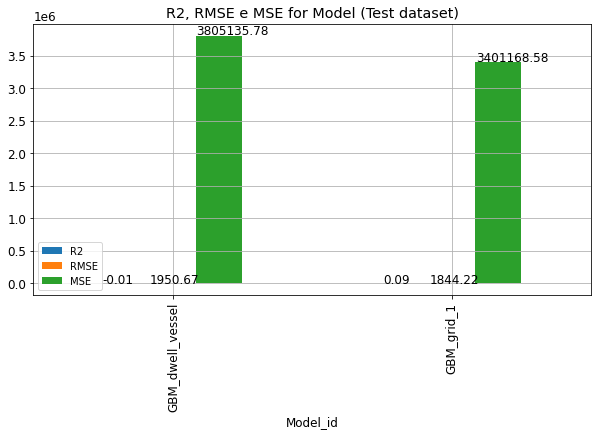

In [82]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:
    #Save all models in H20 format
    h2o.save_model(model=i, path='%s/models/todos/' % OutputPath, force=True)
    
    #Ascertain the performance of all models on the test base
    performance = i.model_performance(test_hdf)
    
    #Salve metrics
    f=open("%s/models/todos/performance_%s.csv" % (OutputPath, i.model_id), 'w')
    f.write(
        str(i.model_id) + ";"
        + str(performance.r2()) + ";"
        + str(performance.mse()) + ';'
        + str(performance.rmse()))
    f.write('\n')
    f.close()
    
    if i.model_id==list_models[0].model_id:
        df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                    'R2': int(performance.r2()*100)/100,
                                    'RMSE': int(performance.rmse()*100)/100,
                                    'MSE': int(performance.mse()*100)/100                                    
                                    }, index=[0])
    else:
        df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                    'R2': int(performance.r2()*100)/100,
                                    'RMSE': int(performance.rmse()*100)/100,
                                    'MSE': int(performance.mse()*100)/100  
                                    }, index=[0]))
ax = df_plot.plot(kind='bar', x="Model_id", title="R2, RMSE e MSE for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

In [83]:
#Consider all models in the history ./models/todos/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/todos/performance_*.csv' % OutputPath)

In [85]:
sort_metric_best_model='RMSE'
#importar todos os modelos testados e imprmie na tela os 10 melhores erdedando per AUC
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/todos/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'R2', 'RMSE', 'MSE')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=True)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : RMSE


index                                     model_id        R2          RMSE  \
0      0  GBM_grid_1_AutoML_1_20220403_231645_model_6  0.095581  3.401169e+06   
1      0           GBM_dwell_vessel_v220220403_231630 -0.011839  3.805136e+06   

           MSE  
0  1844.225741  
1  1950.675724


BEST MODEL: GBM_grid_1_AutoML_1_20220403_231645_model_6



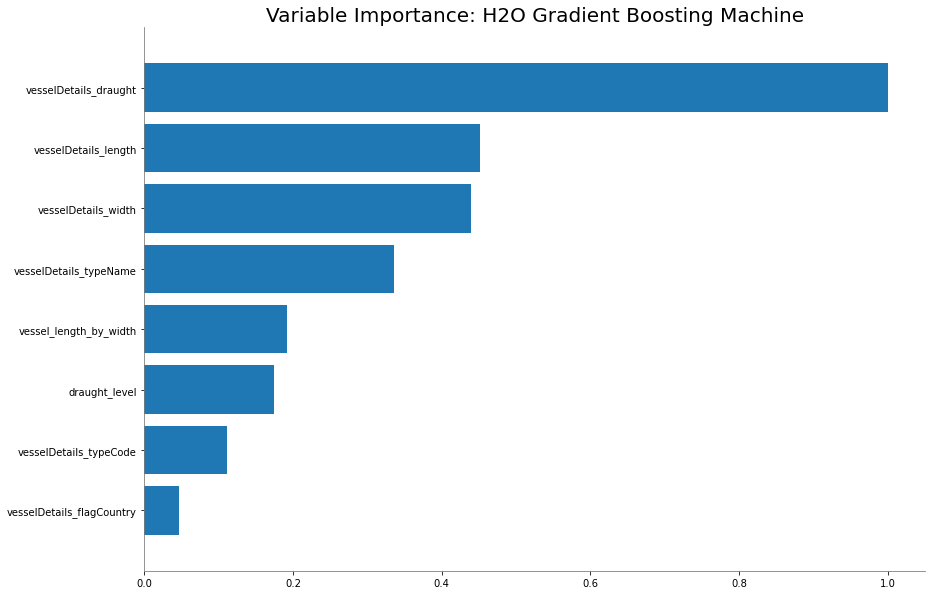

<Figure size 432x288 with 0 Axes>

In [86]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=0

melhor_modelo = h2o.load_model('%s/models/todos/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))

(print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print("Warning: This model doesn't have variable importances")

#### Exporting the best model to Deploy

In [87]:
#Save the H2O model in MOJO format and all the variables of the best model
melhor_modelo = h2o.load_model('%s/models/todos/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))

caminho_modelo_mojo = melhor_modelo.download_mojo('%s/models/melhores/' % OutputPath, get_genmodel_jar=True)
print(caminho_modelo_mojo)
caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/melhores/' % OutputPath, force=True)

D:\OneDrive\Estudo\DataScience\AgileEngine\models\melhores\GBM_grid_1_AutoML_1_20220403_231645_model_6.zip


In [89]:
try:
    features_names= melhor_modelo.varimp(True)
    features_names.to_csv('%s/models/melhores/features_names_%s.csv' % (OutputPath, melhor_modelo.model_id), sep=';')
except Exception as e:
    print("Warning: This model doesn't have variable importances")

#### Calculate Shapley Values using SHAP KernelExplainer for H20 models

#### The SHAP library calculates the Shaley Value of each variable used in the model and shows the individual impact of each variable on the predicted value for each record. To better understand how the SHAP library works, see the link https://github.com/slundberg/shap

In [15]:
class H2oProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1) 
        self.dataframe = pd.DataFrame(X, columns=self.feature_names)
        
        global NUM
        #Variaveis explicativas continuas
        for col_name in NUM:    
            self.dataframe[col_name] = self.dataframe[col_name].astype(float)
            
        global CAT
        for col_name in CAT:    
            self.dataframe[col_name] = self.dataframe[col_name].astype(str)
            self.dataframe = self.dataframe.fillna(value={col_name: 'missing'})
        
        self.h2oframe = h2o.H2OFrame(self.dataframe)
        for col_name in CAT:
            self.h2oframe[col_name] = self.h2oframe[col_name].asfactor()
        
        self.predictions = self.h2o_model.predict(self.h2oframe).as_data_frame().values
        return self.predictions.astype('float64') [:,-1]

In [16]:
#The calculation of the Shapley Value for H20 models takes a while. So it will only be done for 20 records. Increase the sample to deepen your analysis
shap_sample = dataprep_df.query('dataset == "test"').loc[:,(selected_features)].sample(n=22, replace=False, random_state=1)
shap_sample = shap_sample.fillna(0)

In [17]:
h2o_wrapper = H2oProbWrapper(melhor_modelo, selected_features)
h2o_explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, shap_sample)
h2o_shap_values = h2o_explainer.shap_values(shap_sample, nsamples="auto")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%



#### Shapley Main SHAP Graphics

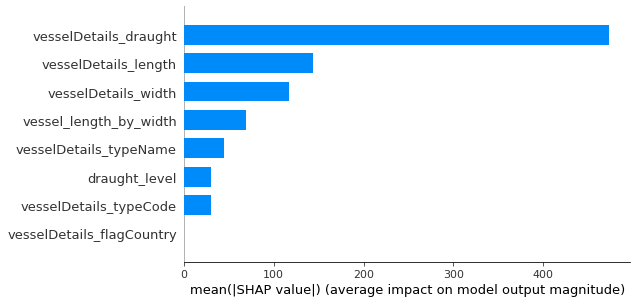

None

In [18]:
fig = shap.summary_plot(h2o_shap_values, shap_sample, plot_type="bar", show=True)
display(fig)

None

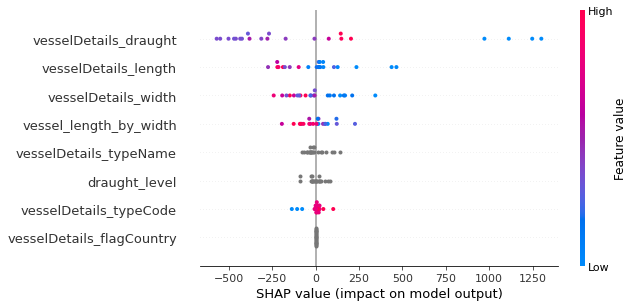

In [19]:
display(shap.summary_plot(h2o_shap_values, shap_sample, show=False))

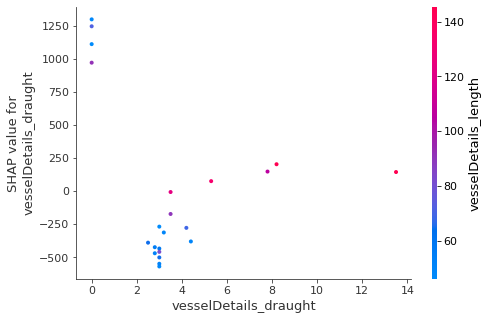

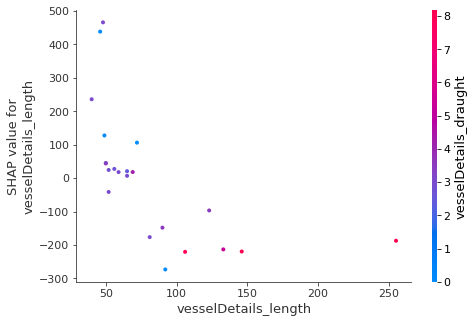

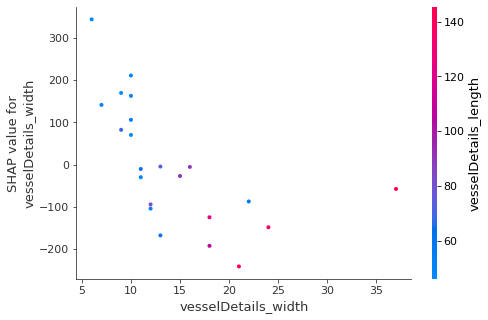

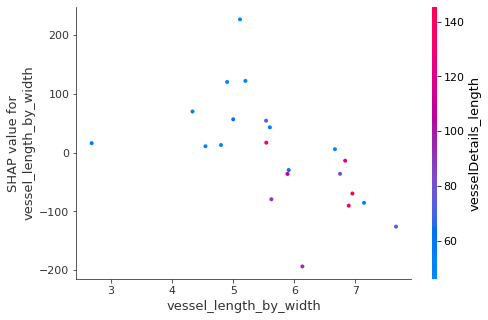

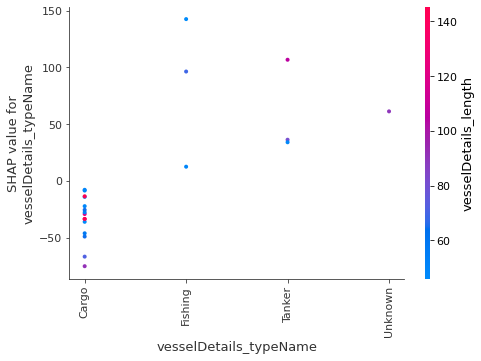

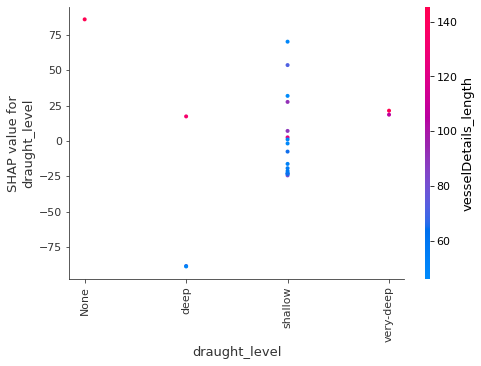

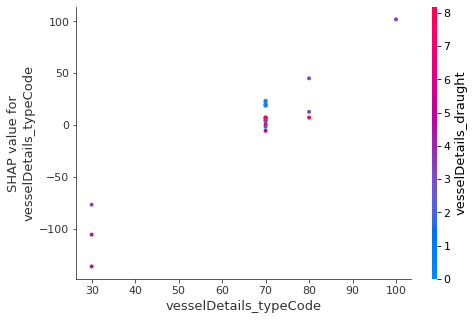

In [20]:
#sort the features indexes by their importance in the model
#(sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(h2o_shap_values),0))

#make SHAP plots of the three most important features
for i in range(7):
    fig=shap.dependence_plot(top_inds[i], h2o_shap_values, shap_sample, show=False)
#     display(fig)